In [4]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings("ignore")

# Patient details file yaml/json
import yaml

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    piqt_distortion_report, snr_report_multi,
    resolution_bars_report, uniformity_report, snr_report
)
from mriqa.phantoms import SIEMENSSHORTBOTTLE, PIQTSP

from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa, phoenix

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

from datetime import datetime

import fmriqa

In [5]:
with open('study.yml') as fp:
    info = yaml.safe_load(fp)
title = info.get('Title', 'Medical Physics Annual QA')
patid, studyid = info['PatID'], info.get('StudyID', '1')
tests = info['Tests']

for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

## Summary
- Tests Performed:
  - Slice shape and Profile
  - Distortion and Field of View
  - In Plane Resolution
  - Ghosting
  - Head Coil SNR
  - Head Coil Image Uniformity

All of the above are acceptable.

In [6]:
text = '''
R. Hartley-Davies
Medical Physics & Bioengineering, UH Bristol
January 2019
'''
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))


In [7]:
NewPage

## Slice Profile

### TO2 Phantom

These are the profiles of 3mm and 5mm slices measured with TO2 for a conventional spin echo with a T<sub>R</sub> of 500ms and a T<sub>E</sub> of 30ms.

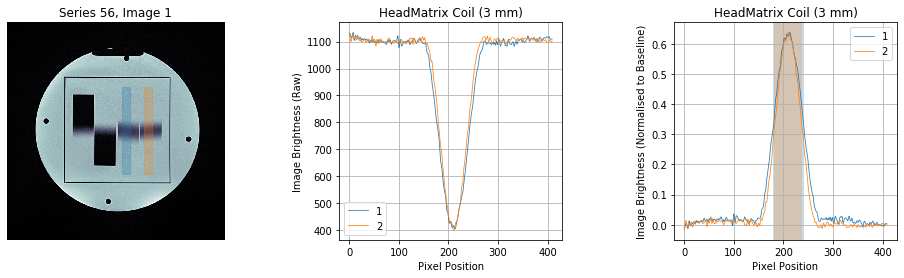

Plate Angle  =  11.7 degrees
FWHM     (1) =  62.0 pixels, or 3.1 mm
FWHM     (2) =  56.1 pixels, or 2.8 mm
FWHM (GMEAN) =  59.0 pixels, or 3.0 mm


In [8]:
# TO2: Slice 3mm
info = tests['SliceProfile_TO2']
patid, stuid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobj = fetch_series(patid, stuid, sernos=series['3mm'])[slices['3mm']]
results = slice_profile_report(dobj, flipped_ud=False, flipped_rl=False)

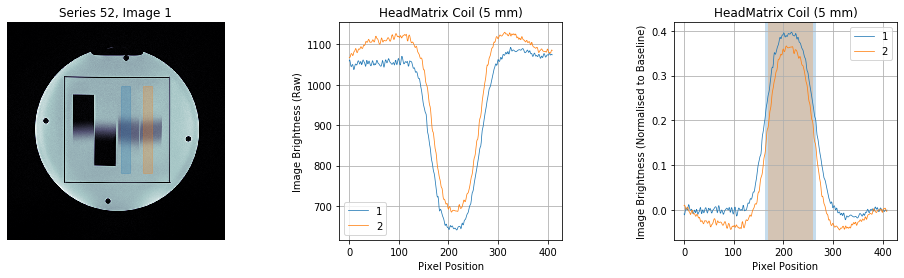

Plate Angle  =  11.7 degrees
FWHM     (1) =  103.3 pixels, or 5.2 mm
FWHM     (2) =  91.4 pixels, or 4.6 mm
FWHM (GMEAN) =  97.2 pixels, or 4.9 mm


In [9]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobj = fetch_series(patid, stuid, sernos=series['5mm'])[slices['5mm']]
result = slice_profile_report(dobj, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [10]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                59.0             3.0
5.0                                97.2             4.9

These are both with the AAPM tolerance of 0.5mm.

In [11]:
NewPage

### PIQT Phantom

These are the profiles of 3mm and 5mm slices measured with the PIQT phantom for a conventional spin echo with a T<sub>R</sub> of 500ms and a T<sub>E</sub> of 30ms.

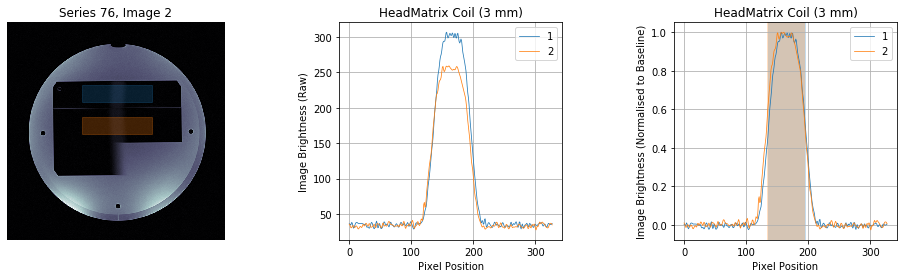

Plate Angle  =  11.7 degrees
FWHM     (1) =  59.8 pixels, or 3.0 mm
FWHM     (2) =  62.0 pixels, or 3.1 mm
FWHM (GMEAN) =  60.8 pixels, or 3.1 mm


In [12]:
info = tests['SliceProfile_PIQT']
patid, stuid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# PIQT 3 mm Slice
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, stuid, sernos=series['3mm'])[slices['3mm']]

results = slice_profile_report(dobj, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

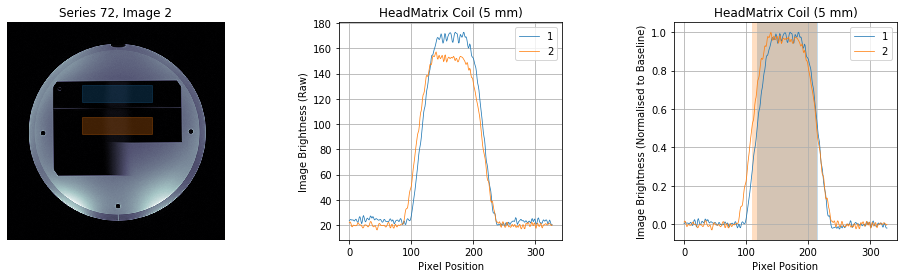

Plate Angle  =  11.7 degrees
FWHM     (1) =  97.4 pixels, or 4.9 mm
FWHM     (2) =  104.5 pixels, or 5.3 mm
FWHM (GMEAN) =  100.9 pixels, or 5.1 mm


In [13]:
# PIQT 5 mm Slice
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, stuid, sernos=series['5mm'])[slices['5mm']]
results = results.append(
    slice_profile_report(dobj, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
)

In [14]:
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                60.8             3.1
5.0                               100.9             5.1

These are both with the AAPM tolerance of 0.5mm.

In [15]:
NewPage

## Geometric Distortion and Scaling

### TO2 Phantom

The TO2 phantom has a square box for distortion and scale measurements.

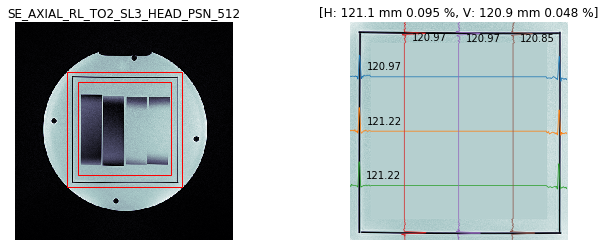

Horizontal Scale / Distortion:    121.1 mm / 0.10 %
Vertical Scale / Distortion:      120.9 mm / 0.05 %


In [16]:
# TO2: Distortion
info = tests['Distortion_TO2']
patid, stuid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, stuid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = distortion_report(dobj, flipped_ud=False, flipped_rl=False)

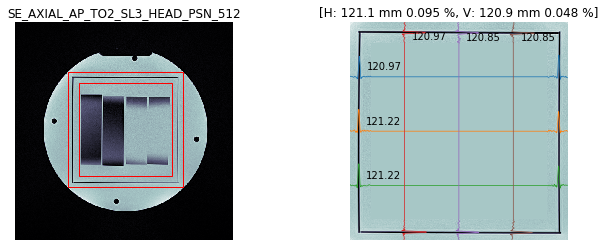

Horizontal Scale / Distortion:    121.1 mm / 0.10 %
Vertical Scale / Distortion:      120.9 mm / 0.05 %


In [17]:
# TO2: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, stuid, sernos=series['AxialAP_Corrected'])[slices['AxialAP_Corrected']]
results = results.append(distortion_report(dobj, flipped_ud=False, flipped_rl=False))

In [18]:
with pd.option_context('display.precision', 3):
    display(
        results[[
            'Orientation', 'PhaseDirection', 'Sensitivity',
            'HorizontalScale', 'HorizontalDistortion',
            'VerticalScale', 'VerticalDistortion'
        ]].rename(columns={
            'PhaseDirection': 'Phase Direction',
            'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
            'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
        })
    )

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
54           Axial              RL        0.239                121.134   
56           Axial              AP        0.239                121.134   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
54                      0.095              120.931                0.048  
56                      0.095              120.890                0.048

The image scale is within 1% of the expected value. Distortion (arising from both gradient nonlinearity and field inhomogeneity) is acceptable at the bandwidth used.

In [19]:
NewPage

### PIQT Phantom

The PIQT phantom has a grid for distortion and scaling.

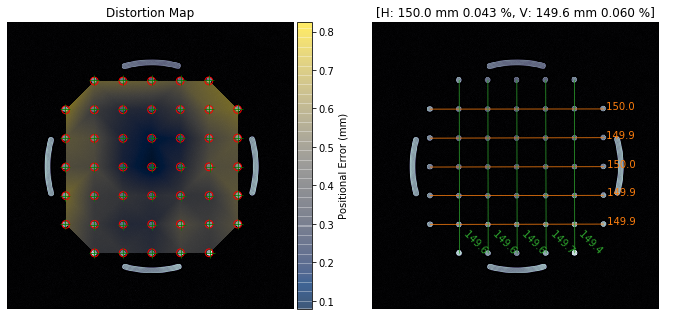

Horizontal Scale / Distortion:    150.0 mm / 0.04 %
Vertical Scale / Distortion:      149.6 mm / 0.06 %


In [20]:
# PIQT: Distortion
info = tests['Distortion_PIQT']

patid, stuid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, stuid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

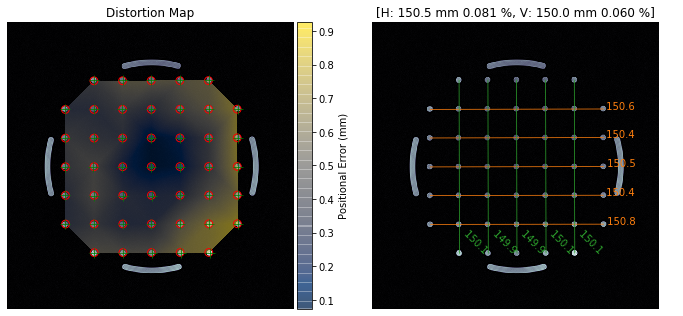

Horizontal Scale / Distortion:    150.5 mm / 0.08 %
Vertical Scale / Distortion:      150.0 mm / 0.06 %


In [21]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, stuid, sernos=series['AxialAP_Corrected'])[slices['AxialAP_Corrected']]
results = results.append(piqt_distortion_report(dobj))

In [22]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
74           Axial              RL        0.239                149.959   
76           Axial              AP        0.239                150.539   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
74                      0.043              149.593                 0.06  
76                      0.081              150.026                 0.06

The image scale is within 1% of the expected value. Distortion (arising from both gradient nonlinearity and field inhomogeneity) is acceptable at the bandwidth used.

In [23]:
NewPage

## Spatial Resolution

The resolution is assessed using the TO4 phantom, which has parallel plates of various separations. These are results for the highest resolution scan (1024x1024).

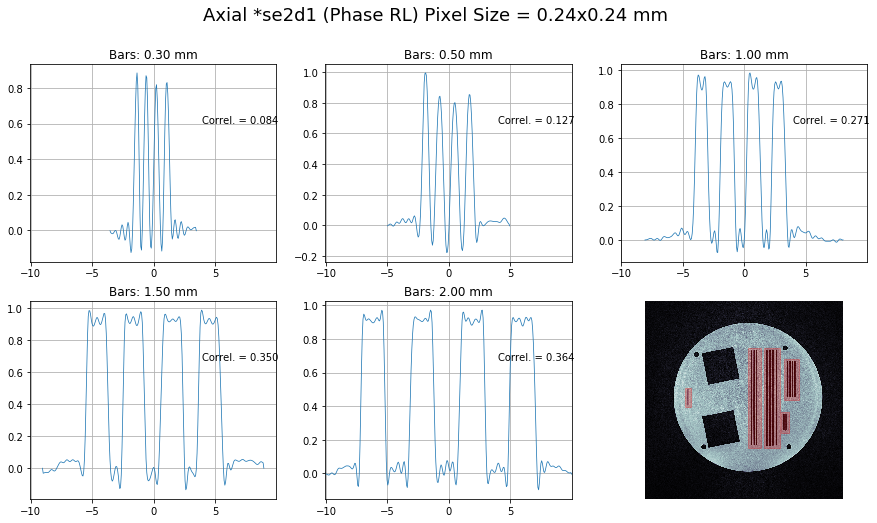

In [24]:
# TO4: Resolution
info = tests['Resolution_TO4']
patid, stuid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

dobj = fetch_series(patid, stuid, sernos=series['AxialRL'])[slices['AxialRL']]
result = resolution_bars_report(dobj, flipped_ud=False, flipped_rl=True)

All the features are adequately resolved.

In [25]:
NewPage

## Ghosting

Image ghosting following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the axial orientation.

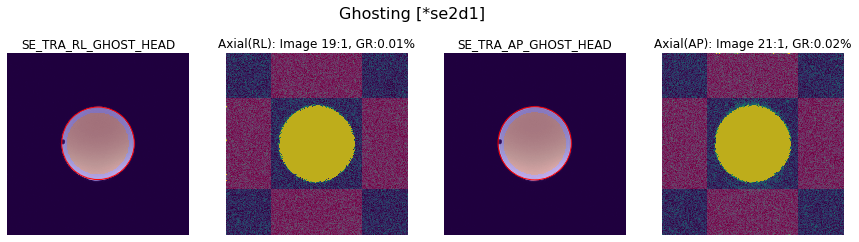

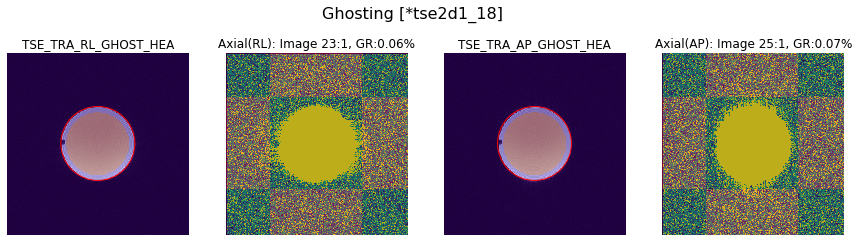

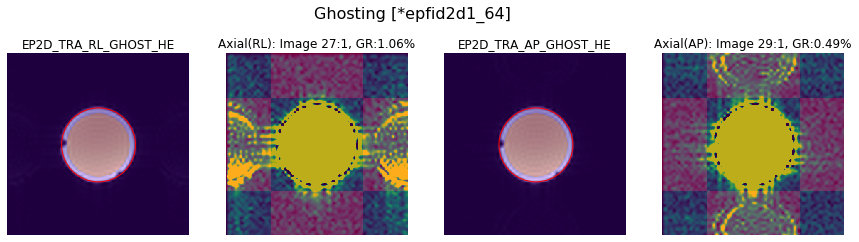

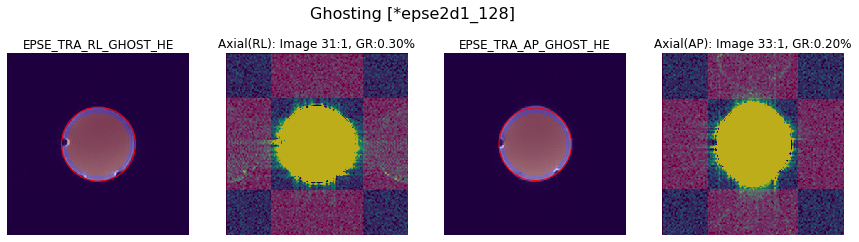

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
19            *se2d1       Axial              RL            0.009
21            *se2d1       Axial              AP            0.019
23        *tse2d1_18       Axial              RL            0.057
25        *tse2d1_18       Axial              AP            0.072
27      *epfid2d1_64       Axial              RL            1.060
29      *epfid2d1_64       Axial              AP            0.489
31      *epse2d1_128       Axial              RL            0.300
33      *epse2d1_128       Axial              AP            0.202

In [26]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is low (less than 1%) for SE, TSE, and SE-EPI. The gradient echo EPI ghosting is slightly above 1% when the secondary read-out direction is right-left.

In [27]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a silicone oil (or water) filled spherical phantom. Results are presented both before and after Siemens `prescan-normalise` intensity correction.

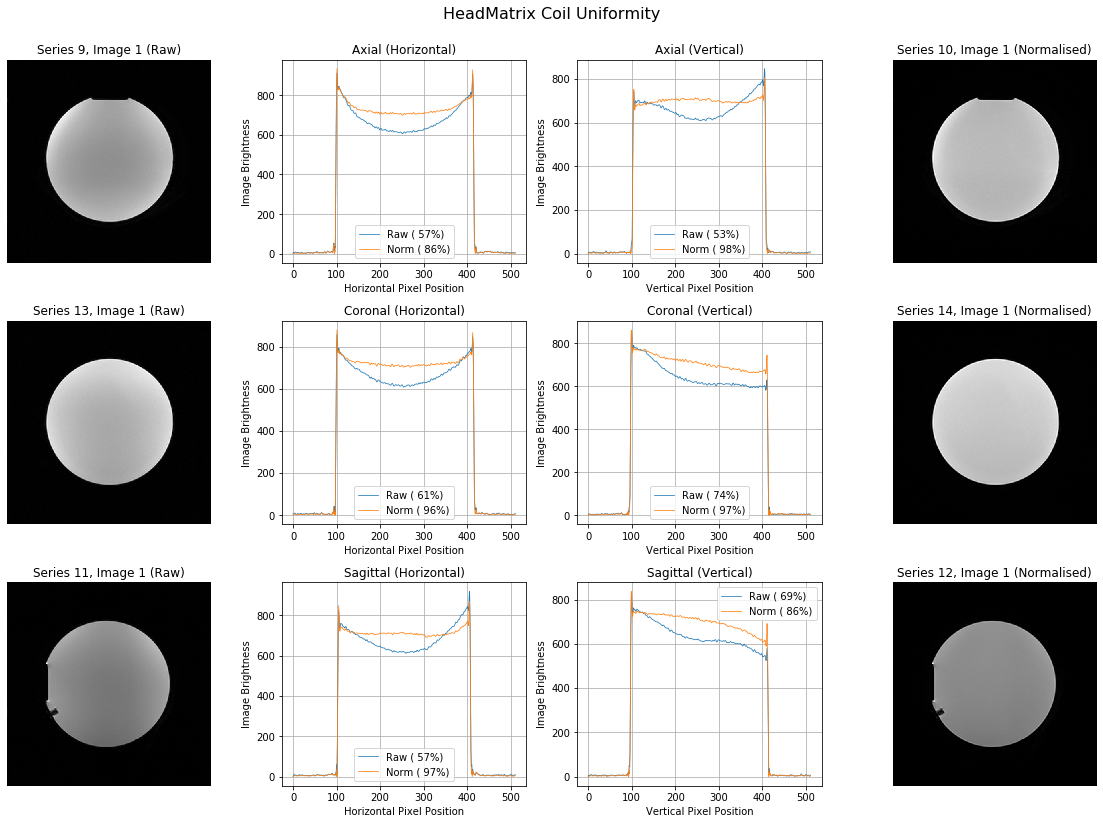

Raw Images


Series No.                         Protocol         Axis  \
Orientation                                                             
Axial                 9  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal              13  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal             11  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    57.37             53.42  
Coronal                  60.82             74.13  
Sagittal                 57.00             68.55

Intensity Normalised Images


Series No.                         Protocol         Axis  \
Orientation                                                             
Axial                10  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal              14  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal             12  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    85.89             98.05  
Coronal                  95.61             97.16  
Sagittal                 97.39             86.48

In [28]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalise` intensity correction is adequate in compensating for this.

In [29]:
NewPage

## Signal to Noise

### Combined Images

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom (this can easily be positioned reproducibly). The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from the mean of two images within the phantom and noise estimated from a background region in their difference.

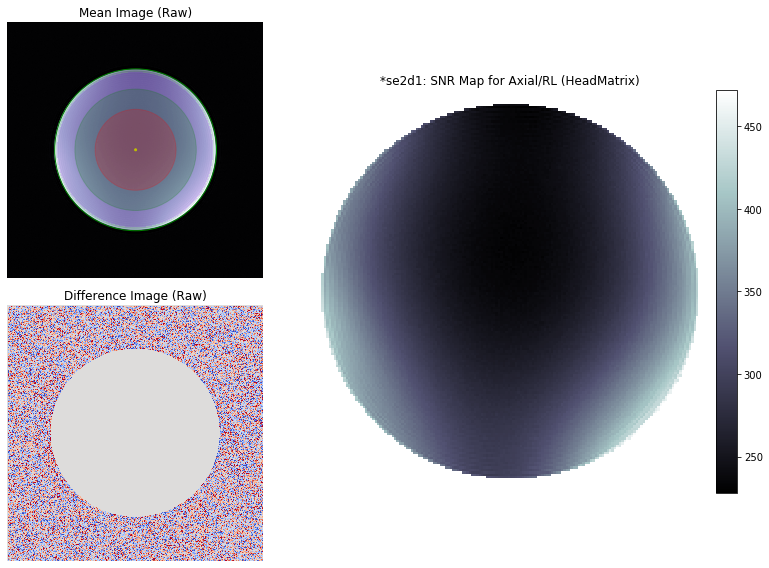

SNR: Raw Images


HeadMatrix
RegionSize            
0.50             251.0
0.75             271.0

In [30]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]], phantom=SIEMENSSHORTBOTTLE)
else:
    results = snr_report(raw_dobjs=[raw_tra[0]], phantom=SIEMENSSHORTBOTTLE)
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are similar to the those we have obtained on other Siemens scanners under these conditions.

In [31]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

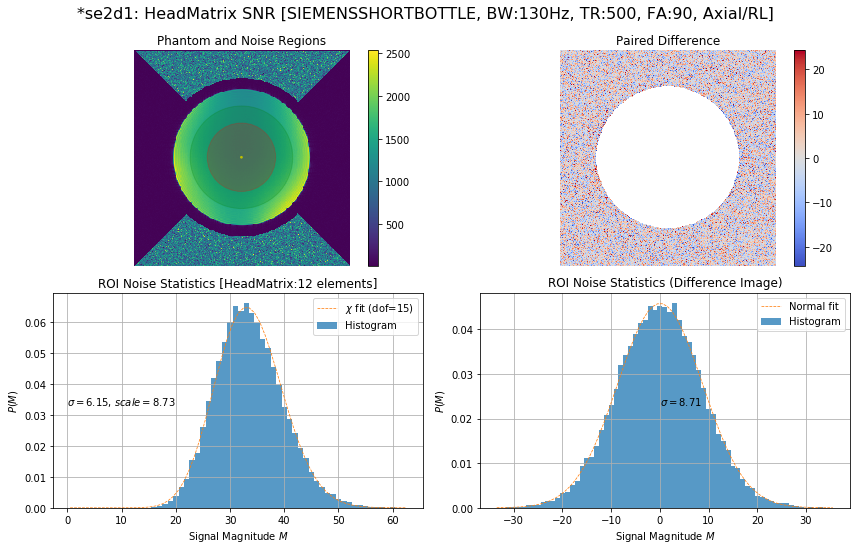

HeadMatrix
0.50      216.55
0.75      233.40

In [32]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

with pd.option_context('display.precision', 2):
    display(snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSSHORTBOTTLE))

## Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM headers.

In [33]:
dobj = dobjs[0]
csa_tags = csa(dobj)
phoenix_tags = phoenix(dobj)

with pd.option_context('display.precision', 3):
    display(pd.DataFrame({
        'ImagingFrequency': [float(dobj.ImagingFrequency)],
        'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
        'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
        'GradientSensitivityX': [
            float(phoenix_tags['sGRADSPEC.flSensitivityX']) * 1e6,
        ],
        'GradientSensitivityY': [
            float(phoenix_tags['sGRADSPEC.flSensitivityY']) * 1e6,
        ],
        'GradientSensitivityZ': [
            float(phoenix_tags['sGRADSPEC.flSensitivityZ']) * 1e6
        ]
    }, index=['Value']).T)

Value
ImagingFrequency         63.687
TransmitterCalibration  199.397
TalesReferencePower     477.788
GradientSensitivityX    265.917
GradientSensitivityY    274.906
GradientSensitivityZ    273.815

In [34]:
HTMLLatex('<hr>', r'\hline')